In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import math
import sklearn.preprocessing
from sklearn.preprocessing import StandardScaler
import os
import subprocess as sp

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
np.random.seed(4)

from models import EarlyStopping, GRU
from utilities import get_NSE, MSE, get_colors, print_notes, inverse_transform_sp
from preprocess import load_data, SampleData

In [2]:
def get_gpu_memory():
    _output_to_list = lambda x: x.decode('ascii').split('\n')[:-1]
    ACCEPTABLE_AVAILABLE_MEMORY = 1024
    COMMAND = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = _output_to_list(sp.check_output(COMMAND.split()))[1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    return memory_free_values

if torch.cuda.is_available():
    device = torch.device("cuda")
if get_gpu_memory()[0] < 1500 :
    device = torch.device("cpu")
print(device)

# Get colors
colors = get_colors()

cuda


In [3]:
# Remove the comments to run the SWAT-SW experiment.
# output_vars = ['SW_ENDmm']
# run_task = 'Train_SSPL_inf_TFIF_SW'

## Remove the comments to run the SWAT-SNO experiment.
# output_vars = ['SNOmm']
# run_task = 'Train_SSPL_inf_TFIF_SNO'

# ## Remove the comments to run the SWAT-SF experiment.
output_vars = ['Q_pred_mm']
run_task = 'Train_SSPL_inf_TFIF_SF'

sim_type = 'full_wsl'
rversion = 'hs32'
#----------------paths-------------------
res_dir = '../results/head_water_SWAT_1000_years/'
exp_dir = res_dir + '{}/rversion_{}/'.format(run_task, rversion)

#--------------------------------------------- load input data -----------------------------
new_data_dir = '../data/1000_year_simulation/'
if sim_type =='full_wsl':
    path = new_data_dir + 'head_water_SWAT_1000_years.csv'
elif sim_type =='nosnow_nofrozen_wsl':
    path = new_data_dir + 'head_water_SWAT_1000_years_no_snow_no_frozen.csv'
elif sim_type =='nosnow_wsl':
    path = new_data_dir + 'head_water_SWAT_1000_years_no_snow.csv'
else:
    raise FileNotFoundError

In [4]:
run_iter = 5
max_iter = run_iter
n_steps = 366
hidden_size = 32
epochs = 500
learning_rate = 0.01
n_classes = len(output_vars)
batch_size = 64
input_size = 7
dropout = 0
nlayers=1
patience = 50

input_vars = ['Date', 'PRECIPmm', 'TMP_MXdgC', 'TMP_MNdgC', 'SOLARMJ/m2', 'WINDM/s', 'RHmd']
assert(len(input_vars) == input_size)
params = np.load(exp_dir + 'params_ss_{}.npy'.format(n_steps),allow_pickle=True).tolist()
print("The network hypermeters : ")
for k,v in params.items():
    if k != "notes":
        print(k,v)
    if k == "notes":
        print()
        print_notes(params['notes'][0])

The network hypermeters : 
learning_rate 0.01
epochs 500
batch_size 64
hidden_size 32
input_size 8
n_steps 366
dropout 0.0
n_classes 1
num_samples_train 0
shift_train 183
num_samples_valid 0
shift_valid 183
num_samples_test 0
shift_test 183
train_percentage 0.5
valid_percentage 0.1

Goal: Simulate the target variable using 7 weather drivers including Date, PRECIPmm, TMP_MXdgC, TMP_MNdgC, SOLARMJ/m2, WINDM/s, RHmd
Target variables: SW_ENDmm, SNOmm, Q_pred_mm
Data: 1000 years simulation data
Split data: First 50% of data as the training set, middle 10% of data as the validation set,  last 40% of data as the testing set
Settings:
- Training: Random mini-batch (RMB) algorithm
- Model: one layer GRU



In [5]:
df = pd.read_csv(path)
feat, label = load_data(df, output_vars, input_vars, input_size)
label_shift = np.expand_dims([label[0,0]] + list(np.squeeze(label[:-1])), axis=1)
feat = np.concatenate((feat, label_shift), axis=-1)
input_size = input_size + 1

In [6]:
# First 50% of data as the training set, middle 10% of data as the validation set, last 40% of data as the testing set.
train_percentage = 0.5
valid_percentage = 0.1
test_percentage = 1 - (train_percentage + valid_percentage)

# Split data
T = feat.shape[0]
train_len = int(T*train_percentage)
valid_len = int(T*valid_percentage)
test_len = T - train_len - valid_len
print(train_len,valid_len,test_len)
train_x = feat[:train_len].copy()
train_y = label[:train_len].copy()
valid_x = feat[train_len:train_len+valid_len].copy()
valid_y = label[train_len:train_len+valid_len].copy()
test_x = feat[train_len+valid_len:].copy()
test_y = label[train_len+valid_len:].copy()

# Normalize data
scaler_x = StandardScaler()
scaler_x.fit(train_x) 
x_train = scaler_x.transform(train_x)
x_valid = scaler_x.transform(valid_x)
x_test = scaler_x.transform(test_x)
scaler_y = StandardScaler()
scaler_y.fit(train_y)
y_train = scaler_y.transform(train_y)
y_valid = scaler_y.transform(valid_y)
y_test = scaler_y.transform(test_y)
m_test = y_test.copy()
m_test[:,:] = 1

# Sample data
## Get indexes
train_idx = np.arange(len(y_train))
valid_idx = np.arange(len(y_valid))
test_idx = np.arange(len(y_test))
## Set stride
num_samples_train = 0
shift_train = int(n_steps / 2)
num_samples_valid = 0
shift_valid = int(n_steps / 2)
num_samples_test = 0
shift_test = int(n_steps / 2)
## Get lists of indexes to sample data. 
train_idx_arr = SampleData(train_idx,n_steps,shift_train,num_samples_train)
num_train_samples = train_idx_arr.shape[0]
valid_idx_arr = SampleData(valid_idx,n_steps,shift_valid,num_samples_valid)
num_valid_samples = valid_idx_arr.shape[0]
test_idx_arr = SampleData(test_idx,n_steps,shift_test,num_samples_test)
num_test_samples = test_idx_arr.shape[0]
## Sample data
x_train_sp_ = x_train[train_idx_arr,:]
y_train_sp_ = y_train[train_idx_arr,:]
m_train_sp_ = y_train_sp_.copy()
m_train_sp_[:,:,:] = 1 # no masking
x_valid_sp_ = x_valid[valid_idx_arr,:]
y_valid_sp_ = y_valid[valid_idx_arr,:]
m_valid_sp_ = y_valid_sp_.copy()
m_valid_sp_[:,:,:] = 1 # no masking
x_test_sp_ = x_test[test_idx_arr,:]
y_test_sp_ = y_test[test_idx_arr,:]
m_test_sp_ = y_test_sp_.copy()
m_test_sp_[:,:,:] = 1 # no masking

# Send data to the device
x_train_sp = torch.from_numpy(x_train_sp_).type(torch.float32).to(device)
y_train_sp = torch.from_numpy(y_train_sp_).type(torch.float32).to(device)
m_train_sp = torch.from_numpy(m_train_sp_).type(torch.float32).to(device)

x_valid_sp = torch.from_numpy(x_valid_sp_).type(torch.float32).to(device)
y_valid_sp = torch.from_numpy(y_valid_sp_).type(torch.float32).to(device)
m_valid_sp = torch.from_numpy(m_valid_sp_).type(torch.float32).to(device)

x_test_sp = torch.from_numpy(x_test_sp_).type(torch.float32).to(device)
y_test_sp = torch.from_numpy(y_test_sp_).type(torch.float32).to(device)
m_test_sp = torch.from_numpy(m_test_sp_).type(torch.float32).to(device)

182622 36524 146098
182622
36524
146098


In [7]:
x_test = torch.from_numpy(x_test).type(torch.float32).to(device)
y_test = torch.from_numpy(y_test).type(torch.float32).to(device)
m_test = torch.from_numpy(m_test).type(torch.float32).to(device)

In [8]:
y_test.shape

torch.Size([146098, 1])

In [9]:
# Analyze the training time
tot_epoch = 0
tot_time = 0
for run_iter in np.arange(max_iter):
    print('Iteration {}'.format(run_iter))
    # # Load the final epoch model
    path_save = exp_dir+"run_iter_{}_final_model.sav".format(run_iter)
    checkpoint=torch.load(path_save)
    epoch = checkpoint['epoch']
    training_time = checkpoint['train_time']
    tot_epoch += epoch
    tot_time += training_time
    print("Total epoch : {}".format(epoch))
    print("Total training time : {:.4f}".format(training_time))
    
print("{:.4f} second/epoch".format(tot_time / tot_epoch))

Iteration 0
Total epoch : 499
Total training time : 23.7422
Iteration 1
Total epoch : 499
Total training time : 26.2978
Iteration 2
Total epoch : 499
Total training time : 25.0057
Iteration 3
Total epoch : 499
Total training time : 26.8451
Iteration 4
Total epoch : 499
Total training time : 29.7513
0.0528 second/epoch


### SSPL-TFIF

In [10]:
pred_test_itrs = []
select = "best"
for run_iter in np.arange(max_iter):
    print('Iteration {}'.format(run_iter))
    # Load the best validation model
    model_trained=GRU(input_size, hidden_size, nlayers, n_classes, dropout)
    if select == "best":
        path_save = exp_dir+"run_iter_{}_best_model.sav".format(run_iter)
        checkpoint=torch.load(path_save)
        model_trained.load_state_dict(checkpoint['model_state_dict'])
    if select == "final":
        path_save = exp_dir+"run_iter_{}_final_model.sav".format(run_iter)
        checkpoint=torch.load(path_save)
        model_trained.load_state_dict(checkpoint['model_state_dict_fs'])
    
    model_trained.to(device)
    epoch = checkpoint['epoch']
    print("Best epoch is {}".format(epoch))
    pred_test_list = torch.zeros(y_test.shape).type(torch.float32).to(device)
    
    with torch.no_grad():
        model_trained.eval()
        hidden_head = model_trained.init_hidden(1)
        for i in range(len(x_test)):
            pred_test,hiddens_test = model_trained(x_test[i][None,None,:],hidden_head)
            hidden_head = hiddens_test
            if i < len(x_test) - 1:
                x_test[i+1,-1] = pred_test[0,0,0]
            pred_test_list[i,0] = pred_test[0,0,0]
            if i % 40000 == 0:
                print(i)

        loss_test = MSE(pred_test_list, y_test, m_test).cpu().numpy()
        pred_test = pred_test_list.cpu().numpy()
        hiddens_test = hiddens_test.cpu().numpy()
    
    # Transform the output back to the original scale.
    pred_test, y_test_ori = inverse_transform_sp(pred_test, y_test.cpu().numpy(), scaler_y, n_classes)
    pred_test_itrs.append(pred_test)

Iteration 0
Best epoch is 240
0
40000
80000
120000
Iteration 1
Best epoch is 225
0
40000
80000
120000
Iteration 2
Best epoch is 304
0
40000
80000
120000
Iteration 3
Best epoch is 183
0
40000
80000
120000
Iteration 4
Best epoch is 202
0
40000
80000
120000


In [11]:
pred_test_itrs = np.squeeze(pred_test_itrs)
rmse_test_itrs = []
nse_test_itrs=[]

for pred_test in pred_test_itrs:
    rmse_test_itrs.append(np.sqrt(MSE(pred_test, np.squeeze(test_y))))
    nse_test_itrs.append(get_NSE(np.squeeze(test_y), pred_test))

In [12]:
with open(exp_dir + "pred_test_agg_stateful_itrs.npy", 'wb') as f:
    np.save(f, pred_test_itrs)

In [13]:
print("Test RMSE Mean")
print(np.round(rmse_test_itrs,3))
print("Test RMSE Mean : {:.3f}".format(np.mean(rmse_test_itrs)))
print("Test RMSE STDV : {:.3f}".format(np.std(rmse_test_itrs)))

Test RMSE Mean
[0.576 0.622 0.65  0.63  0.563]
Test RMSE Mean : 0.608
Test RMSE STDV : 0.033


In [14]:
print("Test NSE")
print(np.round(nse_test_itrs,3))
print("Test NSE Mean : {:.3f}".format(np.mean(nse_test_itrs)))
print("Test NSE STDV : {:.3f}".format(np.std(nse_test_itrs)))

Test NSE
[0.961 0.955 0.95  0.953 0.963]
Test NSE Mean : 0.956
Test NSE STDV : 0.005


In [15]:
pred_test_agg = pred_test_itrs[0]
pred_test_agg = pred_test_agg[:, None]
output_vars = np.asarray(output_vars)
output_var = output_vars[0]
idx = np.where(output_vars == output_var)[0][0]
pred_agg = pred_test_agg[:,idx]
y = test_y[:,idx]

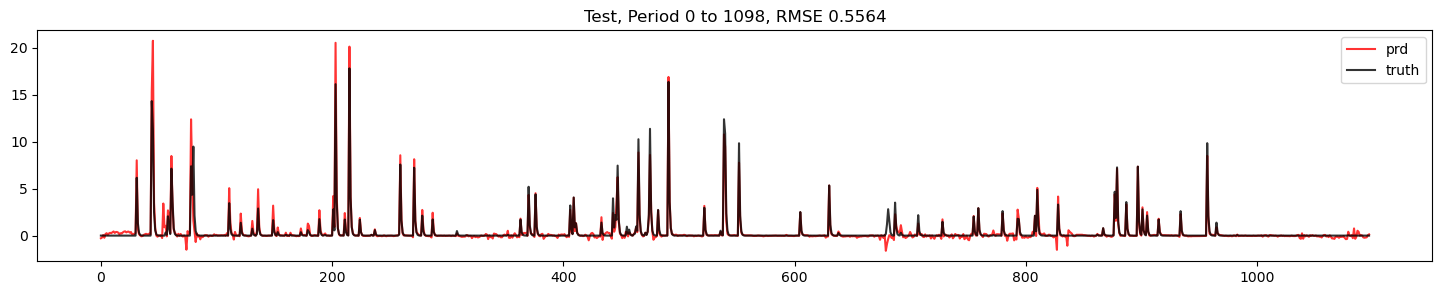

In [16]:
low = 366*0
high = 366*3
period = np.arange(low,high)
pred_snippet = pred_agg[period]
y_snippet = y[period]

ig,ax = plt.subplots(1,1, figsize=(18,3))
ax.plot(period,pred_snippet,c='r',alpha=0.8, label='prd')
ax.plot(period,y_snippet,c='black',alpha=0.8, label='truth')
plt.title("Test, Period {} to {}, RMSE {:.4f}".format(low,high, np.sqrt(MSE(pred_snippet, y_snippet))))
plt.legend()
plt.show()
plt.close()